# Set up

In [1]:
!pip list

Package                   Version
------------------------- --------------
annotated-types           0.7.0
anyio                     4.8.0
appnope                   0.1.4
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 3.0.0
async-lru                 2.0.4
attrs                     25.1.0
babel                     2.17.0
beautifulsoup4            4.13.3
bleach                    6.2.0
certifi                   2025.1.31
cffi                      1.17.1
charset-normalizer        3.4.1
comm                      0.2.2
contourpy                 1.3.1
cryptography              44.0.1
cycler                    0.12.1
debugpy                   1.8.12
decorator                 5.1.1
defusedxml                0.7.1
dill                      0.3.9
executing                 2.2.0
fastjsonschema            2.21.1
fonttools                 4.56.0
fqdn                      1.5.1
h11                       0.14.0
httpcore     

#### Verify that the setup was done correctly

In [2]:
import qiskit
print(qiskit.__version__)

1.3.2


### Setting up the quantum service

#### Imports

In [20]:
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session

# Deutsch Josza Algorithm
The Deutsch Jpsza Algorithm detemines if a given function $f(x)$ is constant or balanced with a quantum approach
Steps:
1. Start with state $\ket{01} = \ket{0} \otimes \ket{1}$
1. Apply H-gate transformation H to both bits
1. Apply function $f$
1. Apply H-tranform to both bits
1. Measure the firest bit of the resulting 2-bit state:
    * If the first bit is 0, we conclude that function $f$ is constant
    * If the first bit is 1, we conclude that function $f$ is not constant


##### Imports

In [13]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.primitives import StatevectorSampler
from qiskit.visualization import plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [14]:
# Set the length of the n-bit string for querying the oracle
n = 4

#### Oracle (Black Box)
The Oracle is the black box in this algorithm that takes an input $x$ and flips the output qubit if $f(x) = 1$.

There are 2 types of oracles:
1. Constant Oracle: For a constant function (always 0 or always 1), the oracle does nothing if always 0 or applies x gate to output qubit if always 1.
1. Balanced Oracle: for a balanced function we can use a CNOT gate controlled by one of the input qubits

In [11]:
def create_oracle(n):
    a = 0
    oracle_type = np.random.randint(
        2
    )  # Sets the oracle type to be either constant (0) or balanced (1),
    oracle_value = np.random.randint(
        2
    )  # and in the case it's constant, to the value it should return 0 or 1

    if oracle_type == 0:
        print(f"The oracle returns a constant value: {oracle_value}")
    else:
        print(f"The oracle returns a balanced function")
        a = np.random.randint(1, 2**n)  # A hidden parameter for the balanced oracle

    return (oracle_type, oracle_value, a)

In [15]:
def deutsch_josza_algorithm(num_bits) -> QuantumCircuit:
    qr = QuantumRegister(
        num_bits + 1
    )  # n input qubits and one qubit for saving the answer
    cr = ClassicalRegister(
        num_bits, name="result"
    )  # Saves the measurement result on the first bit
    circuit_name = "DeutschJosza"
    dj_qc = QuantumCircuit(qr, cr)

    # Create the superposition of all input qubits
    for i in range(num_bits):
        dj_qc.h(qr[i])

    # Flip the second register and apply h-gate
    dj_qc.x(qr[num_bits])
    dj_qc.h(qr[num_bits])

    # Mark the beginning of the oracle
    qu_oracle = create_oracle(num_bits)
    dj_qc.barrier()
    if qu_oracle[0] == 0:
        if qu_oracle[1] == 1:
            dj_qc.x(qr[num_bits])
        else:
            dj_qc.id(qr[num_bits])
    else:
        for i in range(num_bits):
            if qu_oracle[2] & (1 << i):
                dj_qc.cx(qr[i], qr[num_bits])
    # Mark the end of the oracle
    dj_qc.barrier()

    # Apply H-gate after querying the oracle
    for i in range(num_bits):
        dj_qc.h(qr[i])

    # Measure
    for i in range(num_bits):
        dj_qc.measure(qr[i], cr[i])

    return dj_qc

The oracle returns a constant value: 1


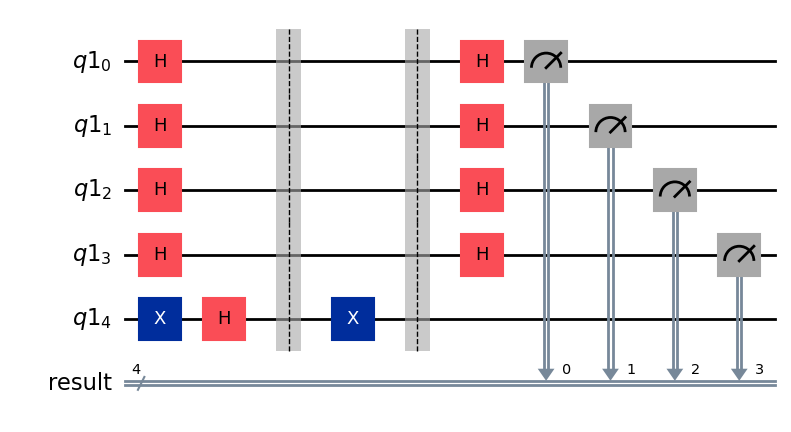

In [16]:
qc = deutsch_josza_algorithm(n)

qc.draw('mpl')

### Testing on Quantum Computer

In [17]:
service = QiskitRuntimeService(
    channel="ibm_quantum",
    token="7821f65d0dd6b850e5efee1028ddc389a6b680756509dd57ee3ce5485f0b7063ef495a3ce96da2ae386537a1734b63fb229452cbdbf7e6146cca3909257b78ab",
)
backend = service.backend("ibm_kyiv")
print(backend.name)
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

isa_circuit = pm.run(qc)

ibm_kyiv


In [18]:
sampler = Sampler(mode=backend)
job = sampler.run([isa_circuit])
# id = job.job_id()
# print(id)

In [50]:

backend = service.backend(name="ibm_kyiv")
print(f"Number of Qubits: {backend.num_qubits}")
job = service.job(job_id='cznnn8xqw630008tqjh0')
job_result = job.result


Number of Qubits: 127


<bound method RuntimeJobV2.result of <RuntimeJobV2('cznnn8xqw630008tqjh0', 'sampler')>>

### Simulator

In [29]:
from qiskit import transpile
from qiskit_aer import Aer, AerSimulator, StatevectorSimulator

In [27]:
sim_backend = AerSimulator()
transpiled_circuit = transpile(qc, sim_backend)

sim_job = sim_backend.run(transpiled_circuit, shots=4096)
counts = sim_job.result().get_counts()

{'0000': 4096}


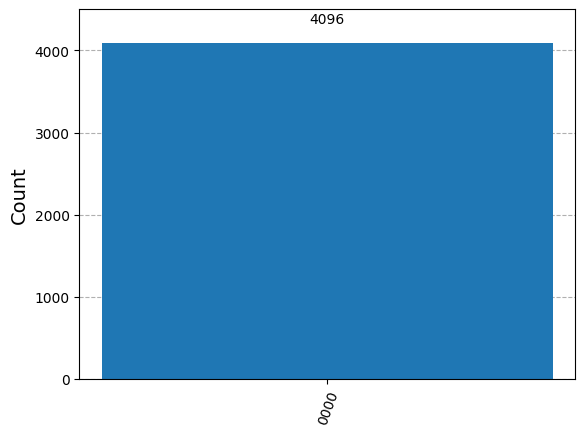

In [31]:
print(counts)
plot_histogram(counts)

In [ ]:
sv_circuit = deutsch_josza_algorithm(n)
sv_sim = StatevectorSimulator()
trans_sv = transpile(sv_circuit, sv_sim)

svresult = sv_sim.run(trans_sv).result()